# 构建波士顿房价预测任务的神经网络模型
波士顿房价预测是一个经典的机器学习任务，类似于程序员世界的“Hello World”。和大家对房价的普遍认知相同，波士顿地区的房价受诸多因素影响。该数据集统计了13种可能影响房价的因素和该类型房屋的均价，期望构建一个基于13个因素进行房价预测的模型，如 **图1** 所示。
<br></br>
<center><img src="https://ai-studio-static-online.cdn.bcebos.com/abce0cb2a92f4e679c6855cfa520491597171533a0b0447e8d51d904446e213e" width="500" hegiht="" ></center>
<center><br>图1：波士顿房价影响因素示意图</br></center>
<br></br>
对于预测问题，可以根据预测输出的类型是连续的实数值，还是离散的标签，区分为回归任务和分类任务。因为房价是一个连续值，所以房价预测显然是一个回归任务。首先我们尝试用最简单的**线性回归模型**解决这个问题，并用神经网络来实现这个模型（python + Numpy）。

## 线性回归模型

假设房价和各影响因素之间能够用线性关系来描述：

$$y = {\sum_{j=1}^Mx_j w_j} + b$$

模型的求解即是通过数据拟合出每个$w_j$和$b$。其中，$w_j$和$b$分别表示该线性模型的权重和偏置。一维情况下，$w_j$ 和 $b$ 是直线的斜率和截距。

线性回归模型使用均方误差作为损失函数（Loss），用以衡量预测房价和真实房价的差异，公式如下：

$$MSE = \frac{1}{n} \sum_{i=1}^n(\hat{Y_i} - {Y_i})^{2}$$


# 数据处理
数据处理包含五个部分：数据导入、数据形状变换、数据集划分、数据归一化处理和封装`load data`函数。数据预处理后，才能被模型调用。
## 读入数据
通过如下代码读入数据，了解下波士顿房价的数据集结构，数据存放在本地目录下housing.data文件中。
```
# 导入需要用到的package
import numpy as np
import json
# 读入训练数据
datafile = './work/housing.data'
data = np.fromfile(datafile, sep=' ')
```
## 数据形状变换
由于读入的原始数据是1维的，所有数据都连在一起。因此需要我们将数据的形状进行变换，形成一个2维的矩阵，每行为一个数据样本（14个值），每个数据样本包含13个XXX（影响房价的特征）和一个YYY（该类型房屋的均价）。
```
# 读入之后的数据被转化成1维array，其中array的第0-13项是第一条数据，第14-27项是第二条数据，以此类推.... 
# 这里对原始数据做reshape，变成N x 14的形式
feature_names = [ 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE','DIS', 
                 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV' ]
feature_num = len(feature_names)
data = data.reshape([data.shape[0] // feature_num, feature_num])
```
## 数据集划分
将数据集划分成训练集和测试集，其中训练集用于确定模型的参数，测试集用于评判模型的效果。
在本案例中，我们将80%的数据用作训练集，20%用作测试集，可以发现共有404个样本，每个样本含有13个特征和1个预测值。
```
ratio = 0.8
offset = int(data.shape[0] * ratio)
training_data = data[:offset]
training_data.shape
```
## 数据归一化处理
对每个特征进行归一化处理，使得每个特征的取值缩放到0~1之间。这样做有两个好处：一是模型训练更高效；二是特征前的权重大小可以代表该变量对预测结果的贡献度（因为每个特征值本身的范围相同）。
```
# 计算train数据集的最大值，最小值，平均值
maximums, minimums, avgs = \
                     training_data.max(axis=0), \
                     training_data.min(axis=0), \
     training_data.sum(axis=0) / training_data.shape[0]
# 对数据进行归一化处理
for i in range(feature_num):
    #print(maximums[i], minimums[i], avgs[i])
    data[:, i] = (data[:, i] - minimums[i]) / (maximums[i] - minimums[i])
```
## 封装成`load data`函数
将上述几个数据处理操作封装成`load data`函数，以便下一步模型的调用，实现方法如下。

In [14]:

def load_data():
    # 从文件导入数据
    datafile = './work/housing.data'
    data = np.fromfile(datafile, sep=' ')

    # 每条数据包括14项，其中前面13项是影响因素，第14项是相应的房屋价格中位数
    feature_names = [ 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', \
                      'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV' ]
    feature_num = len(feature_names)

    # 将原始数据进行Reshape，变成[N, 14]这样的形状
    data = data.reshape([data.shape[0] // feature_num, feature_num])

    # 将原数据集拆分成训练集和测试集
    # 这里使用80%的数据做训练，20%的数据做测试
    # 测试集和训练集必须是没有交集的
    ratio = 0.8
    offset = int(data.shape[0] * ratio)
    training_data = data[:offset]

    # 计算训练集的最大值，最小值，平均值
    maximums, minimums, avgs = training_data.max(axis=0), training_data.min(axis=0), \
                                 training_data.sum(axis=0) / training_data.shape[0]

    # 对数据进行归一化处理
    for i in range(feature_num):
        #print(maximums[i], minimums[i], avgs[i])
        data[:, i] = (data[:, i] - minimums[i]) / (maximums[i] - minimums[i])

    # 训练集和测试集的划分比例
    training_data = data[:offset]
    test_data = data[offset:]
    return training_data, test_data

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import json
import paddle # 用来保存模型

## 训练过程

上述计算过程描述了如何构建神经网络，通过神经网络完成预测值和损失函数的计算。接下来介绍如何求解参数$w$和$b$的数值，这个过程也称为模型训练过程。训练过程是深度学习模型的关键要素之一，其目标是让定义的损失函数$Loss$尽可能的小，也就是说找到一个参数解$w$和$b$，使得损失函数取得极小值。

### 求解方法：梯度下降法

#### **计算梯度**

上面我们讲过了损失函数的计算方法，这里稍微改写，为了使梯度计算更加简洁，引入因子$\frac{1}{2}$，定义损失函数如下：

$$L= \frac{1}{2N}\sum_{i=1}^N{(y_i - z_i)^2}$$

其中$z_i$是网络对第$i$个样本的预测值：

$$z_i = \sum_{j=0}^{12}{x_i^{j}\cdot w_j} + b$$

梯度的定义：

$$𝑔𝑟𝑎𝑑𝑖𝑒𝑛𝑡 = (\frac{\partial{L}}{\partial{w_0}},\frac{\partial{L}}{\partial{w_1}}, ... ,\frac{\partial{L}}{\partial{w_{12}}} ,\frac{\partial{L}}{\partial{b}})$$

可以计算出$L$对$w$和$b$的偏导数：

$$\frac{\partial{L}}{\partial{w_j}} = \frac{1}{N}\sum_{i=1}^N{(z_i - y_i)\frac{\partial{z_i}}{\partial{w_j}}} = \frac{1}{N}\sum_{i=1}^N{(z_i - y_i)x_i^{j}}$$

$$\frac{\partial{L}}{\partial{b}} = \frac{1}{N}\sum_{i=1}^N{(z_i - y_i)\frac{\partial{z_i}}{\partial{b}}} = \frac{1}{N}\sum_{i=1}^N{(z_i - y_i)}$$

从导数的计算过程可以看出，因子$\frac{1}{2}$被消掉了，这是因为二次函数求导的时候会产生因子$2$，这也是我们将损失函数改写的原因。

下面我们考虑只有一个样本的情况下，计算梯度：

$$L= \frac{1}{2}{(y_i - z_i)^2}$$

$$z_1 = {x_1^{0}\cdot w_0} + {x_1^{1}\cdot w_1} + ...  + {x_1^{12}\cdot w_{12}} + b$$

可以计算出：

$$L= \frac{1}{2}{({x_1^{0}\cdot w_0} + {x_1^{1}\cdot w_1} + ...  + {x_1^{12}\cdot w_{12}} + b - y_1)^2}$$

可以计算出$L$对$w$和$b$的偏导数：

$$\frac{\partial{L}}{\partial{w_0}} = ({x_1^{0}\cdot w_0} + {x_1^{1}\cdot w_1} + ...  + {x_1^{12}\cdot w_12} + b - y_1)\cdot x_1^{0}=({z_1} - {y_1})\cdot x_1^{0}$$

$$\frac{\partial{L}}{\partial{b}} = ({x_1^{0}\cdot w_0} + {x_1^{1}\cdot w_1} + ...  + {x_1^{12}\cdot w_{12}} + b - y_1)\cdot 1 = ({z_1} - {y_1})$$

iter 9, loss 5.143394325795511
iter 19, loss 3.097924194225988
iter 29, loss 2.082241020617026
iter 39, loss 1.5673801618157397
iter 49, loss 1.2966204735077431
iter 59, loss 1.1453399043319765
iter 69, loss 1.0530155717435201
iter 79, loss 0.9902292156463155
iter 89, loss 0.9426576903842504
iter 99, loss 0.9033048096880774
iter 109, loss 0.868732003041364
iter 119, loss 0.837229250968144
iter 129, loss 0.807927474161227
iter 139, loss 0.7803677341465797
iter 149, loss 0.7542920908532763
iter 159, loss 0.7295420168915829
iter 169, loss 0.7060090054240882
iter 179, loss 0.6836105084697767
iter 189, loss 0.6622781710179412
iter 199, loss 0.6419520361168637
iter 209, loss 0.622577651786949
iter 219, loss 0.6041045903195837
iter 229, loss 0.5864856570315078
iter 239, loss 0.5696764374763879
iter 249, loss 0.5536350125932015
iter 259, loss 0.5383217588525027
iter 269, loss 0.5236991929680567
iter 279, loss 0.509731841376165
iter 289, loss 0.4963861247069634
iter 299, loss 0.4836302523439023

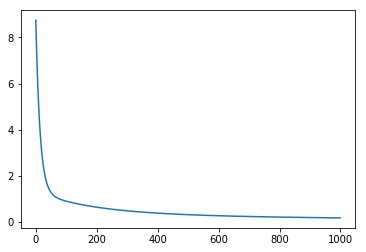

In [16]:
class Network(object):
    def __init__(self, num_of_weights):
        # 随机产生w的初始值
        # 为了保持程序每次运行结果的一致性，此处设置固定的随机数种子
        np.random.seed(0)
        self.w = np.random.randn(num_of_weights, 1)
        self.b = 0.
        
    def forward(self, x):
        z = np.dot(x, self.w) + self.b
        return z
    
    def loss(self, z, y):
        error = z - y
        num_samples = error.shape[0]
        cost = error * error
        cost = np.sum(cost) / num_samples
        return cost
    
    def gradient(self, x, y):
        z = self.forward(x)
        gradient_w = (z-y)*x
        gradient_w = np.mean(gradient_w, axis=0)
        gradient_w = gradient_w[:, np.newaxis]
        gradient_b = (z - y)
        gradient_b = np.mean(gradient_b)        
        return gradient_w, gradient_b
    
    def update(self, gradient_w, gradient_b, eta = 0.01):
        self.w = self.w - eta * gradient_w
        self.b = self.b - eta * gradient_b
        
    def train(self, x, y, iterations=100, eta=0.01):
        losses = []
        for i in range(iterations):
            z = self.forward(x)
            L = self.loss(z, y)
            gradient_w, gradient_b = self.gradient(x, y)
            self.update(gradient_w, gradient_b, eta)
            losses.append(L)
            if (i+1) % 10 == 0:
                print('iter {}, loss {}'.format(i, L))
        return losses

# 获取数据
train_data, test_data = load_data()
x = train_data[:, :-1]
y = train_data[:, -1:]
# 创建网络
net = Network(13)
num_iterations=1000
# 启动训练
losses = net.train(x,y, iterations=num_iterations, eta=0.01)

# 画出损失函数的变化趋势
plot_x = np.arange(num_iterations)
plot_y = np.array(losses)
plt.plot(plot_x, plot_y)
plt.show()

# 【改进】随机梯度下降
在上述程序中，每次损失函数和梯度计算都是基于数据集中的全量数据。对于波士顿房价预测任务数据集而言，样本数比较少，只有404个。但在实际问题中，数据集往往非常大，如果每次都使用全量数据进行计算，效率非常低，通俗地说就是“杀鸡焉用牛刀”。由于参数每次只沿着梯度反方向更新一点点，因此方向并不需要那么精确。一个合理的解决方案是每次从总的数据集中随机抽取出小部分数据来代表整体，基于这部分数据计算梯度和损失来更新参数，这种方法被称作随机梯度下降法（Stochastic Gradient Descent，SGD），核心概念如下：

* mini-batch：每次迭代时抽取出来的一批数据被称为一个mini-batch。
* batch_size：一个mini-batch所包含的样本数目称为batch_size。
* epoch：当程序迭代的时候，按mini-batch逐渐抽取出样本，当把整个数据集都遍历到了的时候，则完成了一轮训练，也叫一个epoch。启动训练时，可以将训练的轮数num_epochs和batch_size作为参数传入。

下面结合程序介绍具体的实现过程，涉及到数据处理和训练过程两部分代码的修改。

#### **数据处理代码修改**

数据处理需要实现拆分数据批次和样本乱序（为了实现随机抽样的效果）两个功能。
#### **训练过程代码修改**

将每个随机抽取的mini-batch数据输入到模型中用于参数训练。训练过程的核心是两层循环：

1. 第一层循环，代表样本集合要被训练遍历几次，称为“epoch”，代码如下：

`for epoch_id in range(num_epochs):`

2. 第二层循环，代表每次遍历时，样本集合被拆分成的多个批次，需要全部执行训练，称为“iter (iteration)”，代码如下：

`for iter_id,mini_batch in emumerate(mini_batches):`

在两层循环的内部是经典的四步训练流程：前向计算->计算损失->计算梯度->更新参数，这与大家之前所学是一致的，代码如下：

                x = mini_batch[:, :-1]
                y = mini_batch[:, -1:]
                a = self.forward(x)  #前向计算
                loss = self.loss(a, y)  #计算损失
                gradient_w, gradient_b = self.gradient(x, y)  #计算梯度
                self.update(gradient_w, gradient_b, eta)  #更新参数


将两部分改写的代码集成到Network类中的`train`函数中，最终的实现如下。

Epoch   0 / iter   0, loss = 1.0281
Epoch   0 / iter   1, loss = 0.5048
Epoch   0 / iter   2, loss = 0.6382
Epoch   0 / iter   3, loss = 0.5168
Epoch   0 / iter   4, loss = 0.1951
Epoch   1 / iter   0, loss = 0.6281
Epoch   1 / iter   1, loss = 0.4611
Epoch   1 / iter   2, loss = 0.4520
Epoch   1 / iter   3, loss = 0.3961
Epoch   1 / iter   4, loss = 0.1381
Epoch   2 / iter   0, loss = 0.5642
Epoch   2 / iter   1, loss = 0.4250
Epoch   2 / iter   2, loss = 0.4480
Epoch   2 / iter   3, loss = 0.3881
Epoch   2 / iter   4, loss = 0.1884
Epoch   3 / iter   0, loss = 0.3921
Epoch   3 / iter   1, loss = 0.5582
Epoch   3 / iter   2, loss = 0.3759
Epoch   3 / iter   3, loss = 0.3849
Epoch   3 / iter   4, loss = 0.1425
Epoch   4 / iter   0, loss = 0.3821
Epoch   4 / iter   1, loss = 0.4382
Epoch   4 / iter   2, loss = 0.3864
Epoch   4 / iter   3, loss = 0.4314
Epoch   4 / iter   4, loss = 0.0471
Epoch   5 / iter   0, loss = 0.4264
Epoch   5 / iter   1, loss = 0.3829
Epoch   5 / iter   2, loss =

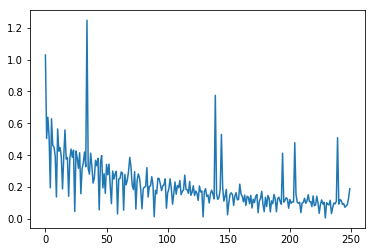

In [17]:
# 获取数据
train_data, test_data = load_data()

# 打乱样本顺序
np.random.shuffle(train_data)

# 将train_data分成多个mini_batch
batch_size = 10
n = len(train_data)
mini_batches = [train_data[k:k+batch_size] for k in range(0, n, batch_size)]

# 创建网络
net = Network(13)

# 依次使用每个mini_batch的数据
for mini_batch in mini_batches:
    x = mini_batch[:, :-1]
    y = mini_batch[:, -1:]
    loss = net.train(x, y, iterations=1)


class Network(object):
    def __init__(self, num_of_weights):
        # 随机产生w的初始值
        # 为了保持程序每次运行结果的一致性，此处设置固定的随机数种子
        #np.random.seed(0)
        self.w = np.random.randn(num_of_weights, 1)
        self.b = 0.
        
    def forward(self, x):
        z = np.dot(x, self.w) + self.b
        return z
    
    def loss(self, z, y):
        error = z - y
        num_samples = error.shape[0]
        cost = error * error
        cost = np.sum(cost) / num_samples
        return cost
    
    def gradient(self, x, y):
        z = self.forward(x)
        N = x.shape[0]
        gradient_w = 1. / N * np.sum((z-y) * x, axis=0)
        gradient_w = gradient_w[:, np.newaxis]
        gradient_b = 1. / N * np.sum(z-y)
        return gradient_w, gradient_b
    
    def update(self, gradient_w, gradient_b, eta = 0.01):
        self.w = self.w - eta * gradient_w
        self.b = self.b - eta * gradient_b
            
                
    def train(self, training_data, num_epochs, batch_size=10, eta=0.01):
        n = len(training_data)
        losses = []
        for epoch_id in range(num_epochs):
            # 在每轮迭代开始之前，将训练数据的顺序随机打乱
            # 然后再按每次取batch_size条数据的方式取出
            np.random.shuffle(training_data)
            # 将训练数据进行拆分，每个mini_batch包含batch_size条的数据
            mini_batches = [training_data[k:k+batch_size] for k in range(0, n, batch_size)]
            for iter_id, mini_batch in enumerate(mini_batches):
                #print(self.w.shape)
                #print(self.b)
                x = mini_batch[:, :-1]
                y = mini_batch[:, -1:]
                a = self.forward(x)
                loss = self.loss(a, y)
                gradient_w, gradient_b = self.gradient(x, y)
                self.update(gradient_w, gradient_b, eta)
                losses.append(loss)
                print('Epoch {:3d} / iter {:3d}, loss = {:.4f}'.
                                 format(epoch_id, iter_id, loss))
        
        return losses

# 获取数据
train_data, test_data = load_data()

# 创建网络
net = Network(13)
# 启动训练
losses = net.train(train_data, num_epochs=50, batch_size=100, eta=0.1)

# 画出损失函数的变化趋势
plot_x = np.arange(len(losses))
plot_y = np.array(losses)
plt.plot(plot_x, plot_y)
plt.show()
